In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
from dateutil.relativedelta import relativedelta

## Reflect Tables into SQLALchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite", echo=False)

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
station =  Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [9]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [10]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set
recent_date = session.query(Measurement.date).group_by(Measurement.date).order_by(Measurement.date.desc()).all()[0][0]
recent_date=dt.strptime(recent_date, "%Y-%m-%d").date()
lydate = (recent_date - relativedelta(years=1))
x = calc_temps(lydate, recent_date)
print(f"Period: {lydate} - {recent_date}")
print(f"Min temp: {x[0][0]}")
print(f"Max temp: {x[0][1]}")
print(f"Average temp: {x[0][2]}")

Period: 2016-08-23 - 2017-08-23
Min temp: 58.0
Max temp: 74.59058295964125
Average temp: 87.0


In [11]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
lydate_ = dt.strftime(lydate, '%d %b %y')
recent_date_ = dt.strftime(recent_date, '%d %b %Y')
y = x[0][2]
yerr = x[0][1] - x[0][0]
x_axis = 0

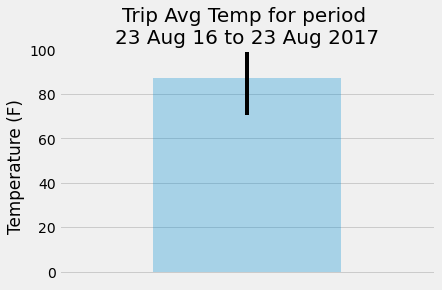

In [90]:
plt.bar(x_axis, y, alpha=0.3, width=0.1, align="center", yerr=yerr)
plt.title(f"Trip Avg Temp for period \n{lydate_} to {recent_date_}", fontsize=20)
plt.ylabel('Temperature (F)')
plt.xticks([])
plt.xlim(-0.1,0.1)
plt.ylim(-5,100)
plt.show()

### Daily Rainfall Average

In [23]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
result = session.query(Measurement.station, station.name, station.latitude, station.longitude, station.elevation, func.sum(Measurement.tobs)).\
    join(station, station.station == Measurement.station, isouter=True).group_by(Measurement.station).\
    filter(Measurement.date > lydate).order_by(func.sum(Measurement.tobs).desc()).all()

rainfall_df = pd.DataFrame(result, columns=['station', 'name', 'latitude', 'longitude', 'elevation', 'total rainfall']) 
rainfall_df

,station,name,latitude,longitude,elevation,total rainfall
0,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,27070.0
1,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,25859.0
2,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,25657.0
3,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,25086.0
4,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,25058.0
5,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,23454.0
6,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,13605.0


### Daily Temperature Normals

In [102]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [106]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'

# Use the start and end date to create a range of dates
date_list_ = pd.Series(pd.date_range(start=start_date, end=end_date))
# Strip off the year and save a list of strings in the format %m-%d
date_list = date_list_.dt.strftime('%m-%d')

# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.
normals = []
for date in date_list:
    tmin,tavg,tmax = np.ravel(daily_normals(date))
    normals.append((tmin,tavg,tmax))
normals

[(67.0, 75.54, 83.0),
 (68.0, 75.60377358490567, 84.0),
 (70.0, 76.61111111111111, 85.0),
 (69.0, 76.71153846153847, 84.0),
 (69.0, 76.14814814814815, 82.0),
 (67.0, 76.25, 83.0),
 (71.0, 77.15686274509804, 83.0)]

In [111]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
daily_normals_df = pd.DataFrame(normals, columns=['tmin', 'tavg', 'tmax'], index=date_list)
daily_normals_df

,tmin,tavg,tmax
08-01,67.0,75.540000,83.0
08-02,68.0,75.603774,84.0
08-03,70.0,76.611111,85.0
08-04,69.0,76.711538,84.0
08-05,69.0,76.148148,82.0
08-06,67.0,76.250000,83.0
08-07,71.0,77.156863,83.0


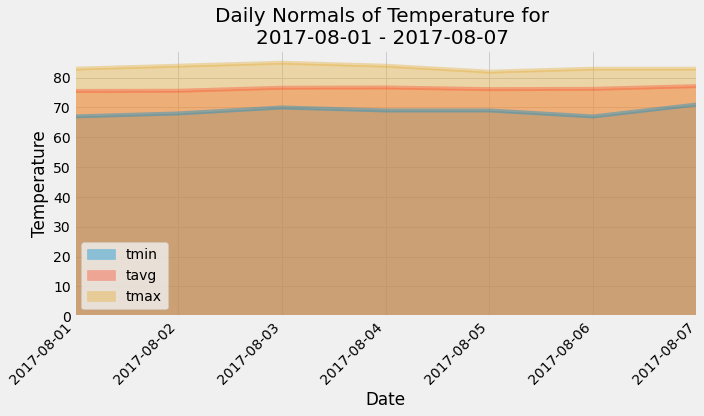

In [112]:
# Plot the daily normals as an area plot with `stacked=False`
fig, ax = plt.subplots(figsize=(10,6))
daily_normals_df.plot.area(ax=ax, stacked=False, alpha=0.4)
plt.xticks(range(len(date_list_)), date_list_.dt.strftime('%Y-%m-%d'), rotation=45, ha='right')
plt.xlim((0,len(date_list_)-1))
plt.ylabel("Temperature")
plt.xlabel("Date")
plt.title(f"Daily Normals of Temperature for \n{start_date} - {end_date} ", fontsize=20, y=1)
plt.tight_layout()


## Close Session

In [113]:
# Close Session
session.close()